### Desafío 1: Preparar el ambiente de trabajo
* Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las
buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples
archivos dentro de la carpeta dump .
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump
utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente
genere un objeto pd.DataFrame que contenga todos los csv.
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import warnings
warnings.filterwarnings(action='ignore')

plt.style.use('seaborn')

import minimal_helpers as helpers

In [2]:
#genero un lista para guardar los csv
file_list = glob.glob(os.getcwd() + '/data/*.csv')

#lista vacia
append_csv = []

for f in file_list:
    #agrega los csv al vector
    append_csv.append(pd.read_csv(f, index_col=None, header=0).drop(columns=['Unnamed: 0']))

df_lyrics = pd.concat(append_csv)
df_lyrics.columns = ['artist', 'genre', 'song', 'lyrics']

In [3]:
df_lyrics.head()

,artist,genre,song,lyrics
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


In [4]:
df_lyrics['genre'].value_counts('%')

rock      0.383191
pop       0.235746
hiphop    0.234635
metal     0.146427
Name: genre, dtype: float64

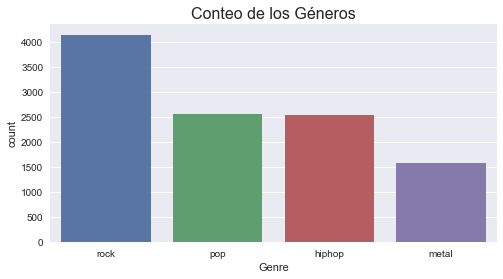

In [5]:
plt.figure(figsize=(8, 4))
sns.countplot(x='genre', data=df_lyrics, order=df_lyrics['genre'].value_counts().index)
plt.xlabel("Genre")
plt.title("Conteo de los Géneros", fontsize=16)
plt.savefig("Por Género")

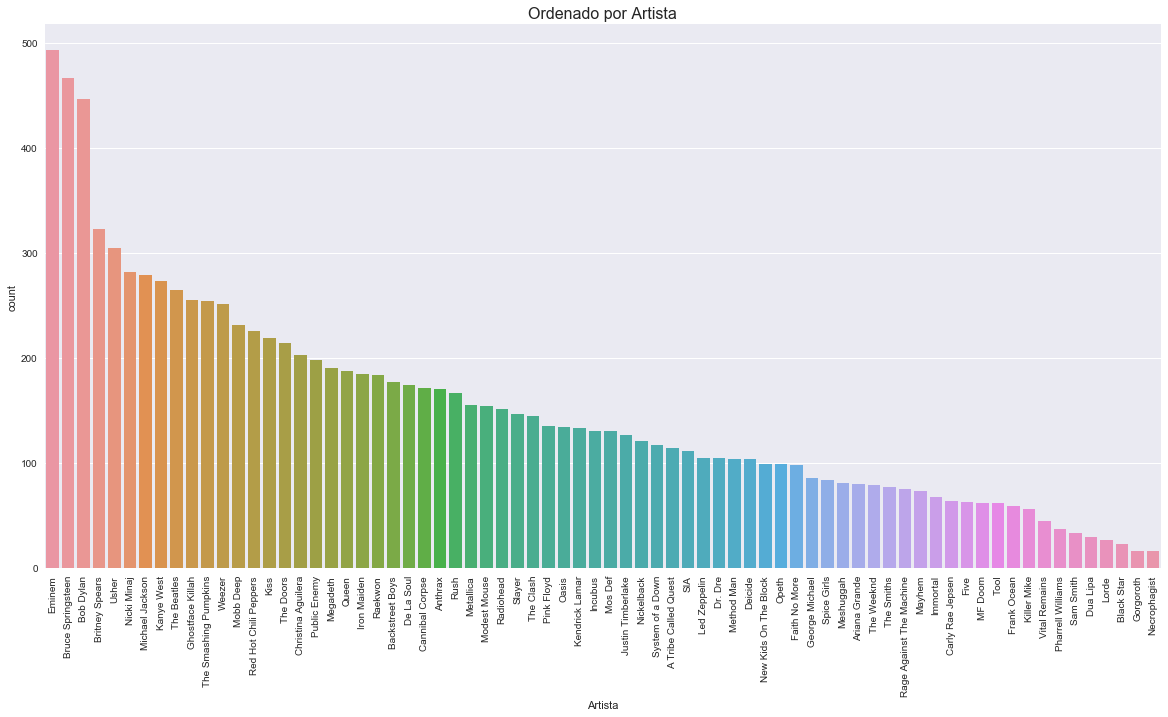

In [30]:
plt.figure(figsize=(20, 10))
sns.countplot(x='artist', data=df_lyrics, order=df_lyrics['artist'].value_counts().index)
plt.xlabel("Artista")
plt.xticks(rotation=90)
plt.title("Ordenado por Artista", fontsize=16)
plt.savefig("OrderByArtist");

### Desafío 2: Matriz de ocurrencias
* Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de
la librería sklearn .
* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
* Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los
resultados en un nuevo objeto

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [8]:
X = df_lyrics.copy()
y = X.pop('genre')
n = .33
seed = 11238

X_hold_in, X_hold_out, y_hold_in, y_hold_out = train_test_split(X, y, test_size=n,
                                                               random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X_hold_in, y_hold_in, test_size=n,random_state=seed)

hold_in_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
hold_in_transformed_features = hold_in_counter.fit_transform(X_hold_in['lyrics'])

hold_out_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
hold_out_transformed_features = hold_out_counter.fit_transform(X_hold_out['lyrics'])

train_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
train_transformed_feats = train_counter.fit_transform(X_train['lyrics'])
test_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
test_transformed_feats = test_counter.fit_transform(X_test['lyrics'])

### Desafío 3: Entrenamiento del Modelo
* Importe sklearn.decomposition.LatentDirichletAllocation y
sklearn.model_selection.GridSearchCV .
* Genere una búsqueda de grilla con los siguientes hiperparámetros:
n_components: [5, 10, 15] .
learning_decay: [0.7, 0.5] .
* Entrene la búsqueda de grilla con las letras en un formato vectorizado con
CountVectorizer .
* Reporte brevemente cuál es la mejor combinación de hiperparámetros.

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [10]:
n_components = [5, 10, 15]
learning_decay = [0.7, 0.5]
param_grid = dict(n_components=n_components, learning_decay=learning_decay)

cv_lda_model = GridSearchCV(LatentDirichletAllocation(learning_method='online'), param_grid=param_grid, 
                            n_jobs=-1).fit(hold_in_transformed_features)

In [11]:
print("La mejor combinación es:", cv_lda_model.best_params_)

La mejor combinación es: {'learning_decay': 0.7, 'n_components': 5}


### Desafío 4 : Inferencia e Identificación de Tópicos
* En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de
atributos de las letras.
* Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras
asociadas con éste. Puede implementar la siguiente línea de código para identificar las
principales palabras en un tópico:
* Comente a qué tópicos está asociada cada clase inferida.

In [12]:
best_lda = cv_lda_model.best_estimator_
best_lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [13]:
helpers.identify_words_associated(best_lda, # insertamos el mejor modelo
                                  hold_in_counter, # insertamos el contador de ocurrencias
                                  20) # cantidad de palabras por tópico

Tópico: 1		
niggas uh niggaz ma gon rock fuckin rap bitches huh game wit check da beat word chorus gettin bout damn
Tópico: 2		
na tonight ha body dre eminem hands dr shady hang boys girls gimme eh hello step sexy fucking alright hee
Tópico: 3		
death la blood pain hell war kill lost fear earth fight lies power burn truth evil rise hate cold dark
Tópico: 4		
everybody going whoa believe crazy wrong somebody thought wish kiss friends coming didn maybe happy help told waiting getting work
Tópico: 5		
ooh ah forever rock fall yes wait song tonight sun moment roll true bring mama lord woman dance dream days


El __tópico 1 y 2__ están asociados a la clase `Hiphop`, el __tópico 3__ a la clase `Metal`, el __tópico 4__ está relacionado con `Pop`y por el último el __tópico 5__ `Rock`.

### Desafío 5: Identificación de probabilidades
* En base a la información generada, es posible identificar cuales van a ser los géneros más
probables de ocurrir para un artista.
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos
original. Podemos implementar esto de la siguiente manera:
* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente
brevemente cuales son las principales asociaciones existentes.
* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista
específico.
* Grafique la distribución de las probabilidades para algún artista en específico.

In [14]:
infer_df = helpers.identify_most_likely_topic(best_lda, #mejor modelo
                                              hold_in_counter, # contador de ocurrencias
                                              hold_in_transformed_features, # texto tokenizado
                                              X_hold_in) #datos a insertar

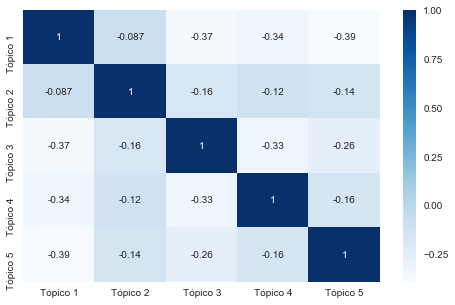

In [22]:
plt.figure(figsize=(8, 5))
matriz_topicos = infer_df.loc[:, 'Tópico 1':'Tópico 5'].corr()
sns.heatmap(matriz_topicos, annot=True, cmap="Blues");

Tópico 2    0.041441
Tópico 5    0.319010
Tópico 3    0.220371
Tópico 1    0.113125
Tópico 4    0.306089
dtype: float64

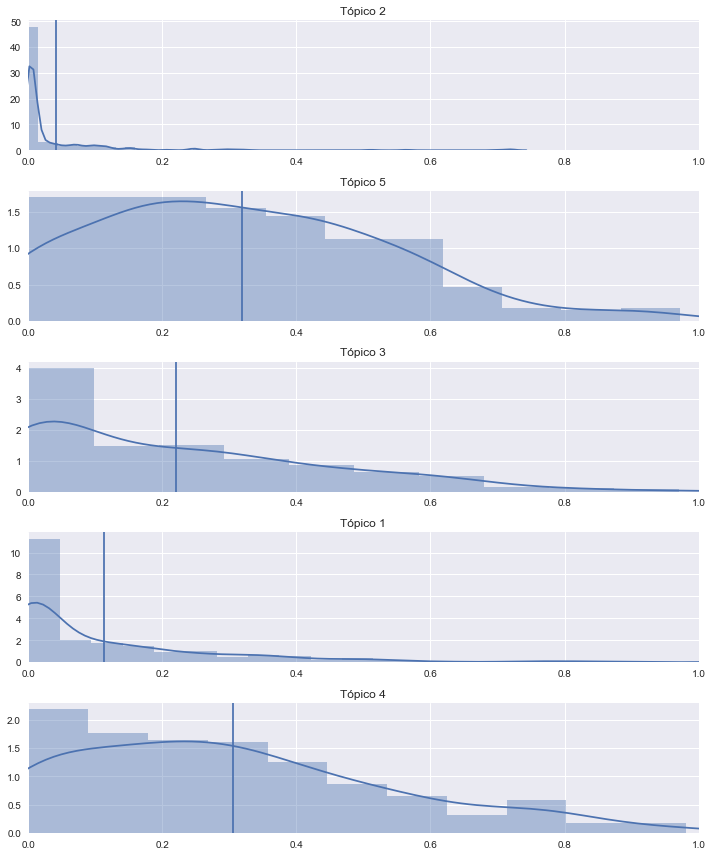

In [24]:
plt.figure(figsize=(10, 12))
helpers.report_artist_topic(infer_df, 'Bob Dylan')

Tópico 2    0.148377
Tópico 5    0.062826
Tópico 3    0.102515
Tópico 1    0.520916
Tópico 4    0.165386
dtype: float64

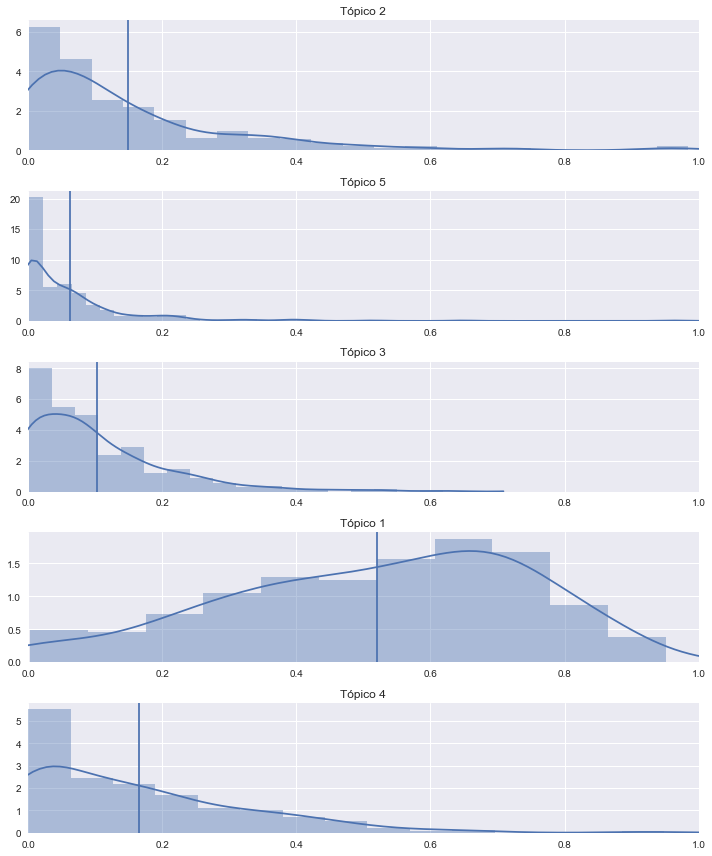

In [25]:
plt.figure(figsize=(10, 12))
helpers.report_artist_topic(infer_df, 'Eminem')

Tópico 2    0.037959
Tópico 5    0.203984
Tópico 3    0.550336
Tópico 1    0.024336
Tópico 4    0.183377
dtype: float64

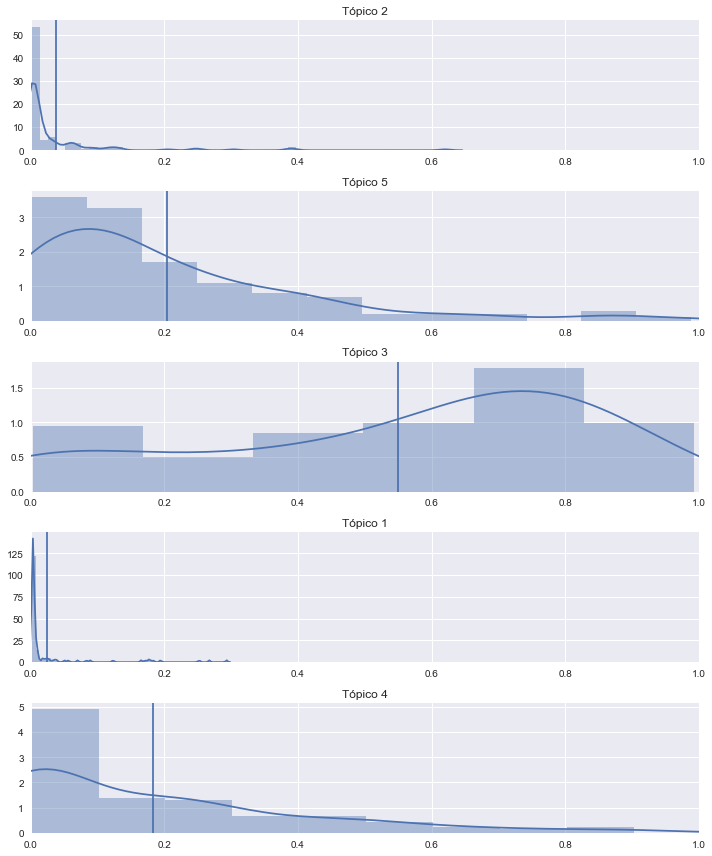

In [31]:
plt.figure(figsize=(10, 12))
helpers.report_artist_topic(infer_df, 'Iron Maiden')

Tópico 2    0.063303
Tópico 5    0.178969
Tópico 3    0.055133
Tópico 1    0.272877
Tópico 4    0.429667
dtype: float64

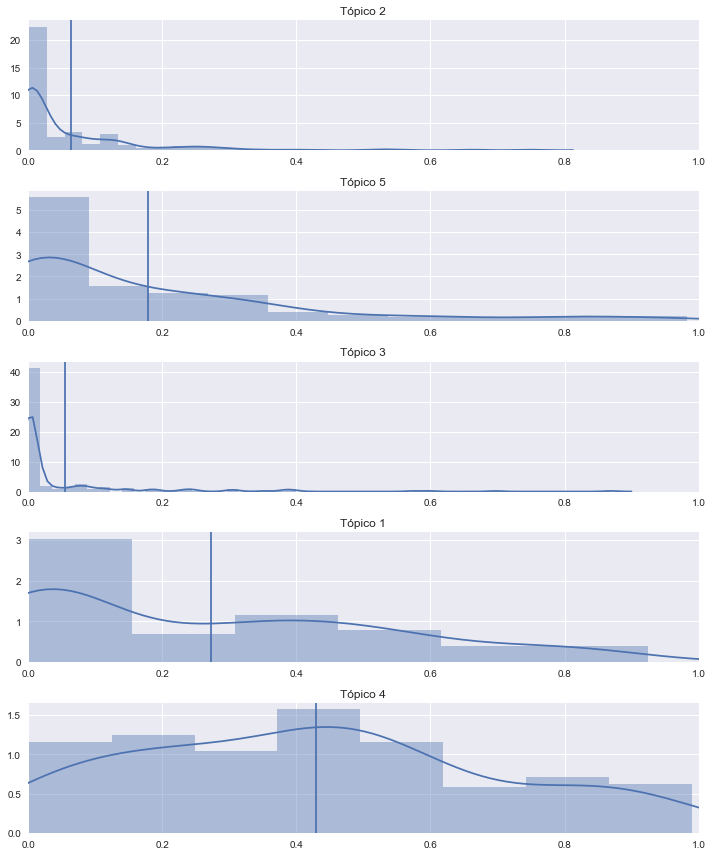

In [32]:
plt.figure(figsize=(10, 12))
helpers.report_artist_topic(infer_df, 'Usher')